# A bit about Spark

*Please run this notebook on [DataBricks Community edition](https://accounts.cloud.databricks.com/)*

## Why Spark 

- Fast..
- in memory computation
- data cached in memory for future usage.
- Multiple language APIs: Java, Scala, Python
- Easier to use: functional API

## Spark interfaces

There are three key Spark interfaces that you should know about.

### Resilient Distributed Dataset (RDD)
Apache Spark’s first abstraction was the RDD. It is an interface to a sequence of data objects that consist of one or more types that are located across a collection of machines (a cluster). RDDs can be created in a variety of ways and are the “lowest level” API available. While this is the original data structure for Apache Spark, you should focus on the DataFrame API, which is a superset of the RDD functionality. The RDD API is available in the Java, Python, and Scala languages.
### DataFrame
These are similar in concept to the DataFrame you may be familiar with in the pandas Python library and the R language. The DataFrame API is available in the Java, Python, R, and Scala languages.
### Dataset
A combination of DataFrame and RDD. It provides the typed interface that is available in RDDs while providing the convenience of the DataFrame. The Dataset API is available in the Java and Scala languages.
In many scenarios, especially with the performance optimizations embedded in DataFrames and Datasets, it will not be necessary to work with RDDs. But it is important to understand the RDD abstraction because:  

   


- The RDD is the underlying infrastructure that allows Spark to run so fast and provide data lineage.
- If you are diving into more advanced components of Spark, it may be necessary to use RDDs.
- The visualizations within the Spark UI reference RDDs.

When you develop Spark applications, you typically use DataFrames and Datasets.

## Lazy Evaluation

Spark is lazy..

There are two types of oprerations in Spark

- **Transformations** - It builds a new RDD from the existing one. It transfers the dataset to the function and then returns the new dataset. Instead of executing it, it just remember the transformations applied to some base dataset (e.g. a file). The transformations are only computed when an action requires a result to be returned to the driver program.
- **Actions** - It turns final result to driver program or corresponds it to the external data store.

### First create some fake data 

- here we create data in Pandas and then load it into Spark DF
  - Other ways to load data:
    - S3
    - Hive
    - Hadoop HDFS
    - ...
  - Formats:
    - .txt
    - .csv
    - .json 
    - Parquet 
    - etc.

In [5]:
## borrowe from here https://github.com/Rdatatable/data.table/wiki/Benchmarks-:-Grouping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# randChar is workaround for MemoryError in mtrand.RandomState.choice
# http://stackoverflow.com/questions/25627161/how-to-solve-memory-error-in-mtrand-randomstate-choice
def randChar(f, numGrp, N) :
   things = [f%x for x in range(numGrp)]
   return [things[x] for x in np.random.choice(numGrp, N)]

def randFloat(numGrp, N) :
   things = [round(100*np.random.random(),4) for x in range(numGrp)]
   return [things[x] for x in np.random.choice(numGrp, N)]

N=int(1e7)
K=100
DF = pd.DataFrame({
  'id1' : randChar("id%03d", K, N),       # large groups (char)
  'id2' : randChar("id%03d", K, N),       # large groups (char)
  'id3' : randChar("id%010d", N//K, N),   # small groups (char)
  'id4' : np.random.choice(K, N),         # large groups (int)
  'id5' : np.random.choice(K, N),         # large groups (int)
  'id6' : np.random.choice(N//K, N),      # small groups (int)
  'v1' :  np.random.choice(5, N),         # int in range [1,5]
  'v2' :  np.random.choice(5, N),         # int in range [1,5]
  'v3' :  randFloat(100,N)                # numeric e.g. 23.5749
})

In [6]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
id1 object
id2 object
id3 object
id4 int64
id5 int64
id6 int64
v1 int64
v2 int64
v3 float64
dtypes: float64(1), int64(5), object(3)
memory usage: 686.6+ MB

### Spark Session vs. Spark context

- Since Spark 2.0, Spark Session is the unified entry point to Spark Application. So, you don't need to deal with SQL context, Hive context etc. 
- Spark Session is preloaded in Databricks

In [8]:
# Enable Arrow-based columnar data transfers
# try not to use Arrow?
# more on https://docs.databricks.com/spark/latest/spark-sql/spark-pandas.html
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

sparkdf = spark.createDataFrame(DF)

# also registered it as a table
sparkdf.createOrReplaceTempView('data') # you can also use it with SQL 

Take a peek at the data

In [10]:
sparkdf.show(10)

+-----+-----+------------+---+---+-----+---+---+-------+
 id1| id2| id3|id4|id5| id6| v1| v2| v3|
+-----+-----+------------+---+---+-----+---+---+-------+
id093|id037|id0000099855| 13| 94|84672| 1| 0| 6.6723|
id057|id048|id0000091948| 21| 46|87635| 0| 2| 60.554|
id080|id029|id0000013212| 85| 73|91727| 3| 0| 3.0817|
id042|id055|id0000047319| 43| 51|37842| 3| 2|93.0094|
id064|id068|id0000033052| 3| 61|61179| 2| 2| 6.6723|
id062|id033|id0000057827| 68| 31|83079| 1| 2|43.9649|
id046|id047|id0000062867| 11| 23|86415| 1| 1|93.7975|
id078|id035|id0000005050| 4| 73|48195| 3| 2|87.0421|
id073|id013|id0000072890| 5| 97|71305| 4| 2|28.0899|
id067|id003|id0000041847| 23| 55|64485| 3| 4|64.9329|
+-----+-----+------------+---+---+-----+---+---+-------+
only showing top 10 rows

In [11]:
def shape(sparkdf):
  return sparkdf.count(), len(sparkdf.columns)

shape(sparkdf)

Out[ 5 ]: (10000000, 9)

### Some sample operations in Spark

#### Print summary statistics

In [14]:
sparkdf.describe('v3').show()

+-------+------------------+
summary| v3|
+-------+------------------+
 count| 10000000|
 mean| 52.50805092548781|
 stddev|29.175026255920482|
 min| 0.4422|
 max| 99.8518|
+-------+------------------+

#### Filter and select column

- .filter() == .where()

In [16]:
sparkdf \
  .filter(sparkdf['v1'] > 2)\
  .select(['id1', 'v1'])\
  .sort('v1')\
#   .show(10)         # this is the exec?tuion step

Out[ 6 ]: DataFrame[id1: string, v1: bigint]

#### Groupby and Aggregations

In [18]:
sparkdf.select(["id1", "v1"])\
  .groupBy(["id1", "v1"])\
  .agg({'v1': 'max'})\
  .show()

+-----+---+-------+
 id1| v1|max(v1)|
+-----+---+-------+
id008| 0| 0|
id057| 2| 2|
id087| 3| 3|
id040| 1| 1|
id055| 2| 2|
id084| 0| 0|
id076| 4| 4|
id059| 0| 0|
id053| 0| 0|
id024| 2| 2|
id064| 4| 4|
id020| 3| 3|
id031| 1| 1|
id068| 1| 1|
id044| 2| 2|
id073| 2| 2|
id037| 0| 0|
id077| 1| 1|
id071| 4| 4|
id084| 2| 2|
+-----+---+-------+
only showing top 20 rows

### Load back to pandas and visualize

- Pandas is used for smaller datasets and PySpark is used for larger datasets. 
- After you have reduced the size of your data with PySpark
- You can load it back to Pandas for visualization with the tool of your choice

In [20]:
series = sparkdf\
  .select('v3')\
  .filter(sparkdf['v3'] > 90)\
  .toPandas()

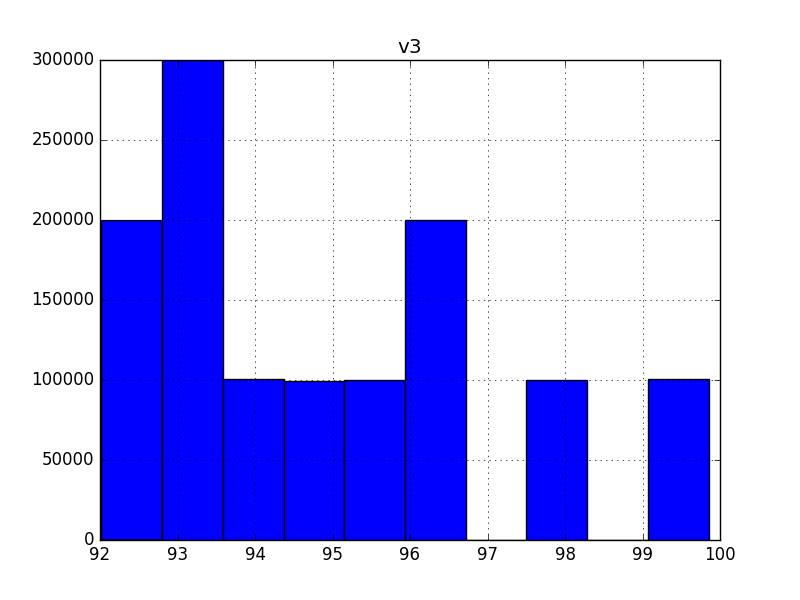

In [21]:
series.hist()
display()

In [22]:
# or more easily

display(sparkdf)

id1,id2,id3,id4,id5,id6,v1,v2,v3
id093,id037,id0000099855,13,94,84672,1,0,6.6723
id057,id048,id0000091948,21,46,87635,0,2,60.554
id080,id029,id0000013212,85,73,91727,3,0,3.0817
id042,id055,id0000047319,43,51,37842,3,2,93.0094
id064,id068,id0000033052,3,61,61179,2,2,6.6723
id062,id033,id0000057827,68,31,83079,1,2,43.9649
id046,id047,id0000062867,11,23,86415,1,1,93.7975
id078,id035,id0000005050,4,73,48195,3,2,87.0421
id073,id013,id0000072890,5,97,71305,4,2,28.0899
id067,id003,id0000041847,23,55,64485,3,4,64.9329


For more documentations of Spark DataFrame API or Spark in general
- https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html
- http://spark.apache.org/docs/latest/rdd-programming-guide.html
- https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame
- https://spark.apache.org/docs/preview/sql-programming-guide.html